In [ ]:
!pip install faker

/tmp/ipython-input-15-1986409626.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['2023/05/20', '31-12-2024', None, '2024-01-02', 'julio 2023', nan, '2024/03/15']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  ventas.loc[np.random.choice(ventas.index, 7), 'fecha'] = [
/tmp/ipython-input-15-1986409626.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan, 50000, 0, None, -100]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ventas.loc[np.random.choice(ventas.index, 5), 'monto'] = [np.nan, 50000, 0, None, -100]



Clientes:
   id_cliente                      nombre  edad       ciudad  ingreso
0           1  Paulino Torrijos Sanmiguel  28.0          NaN    646.0
1           2       Elpidio Prado-Ramírez  29.0   Valparaíso   2076.0
2           3          Micaela Pedro Moll  51.0      Sntiago   2489.0
3           4      Macario Beltran Águila   NaN  Antofagasta   1808.0
4           5            Isidro Cañizares   NaN  Vina del Mr    926.0

Resumen de dataframe clientes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_cliente  100 non-null    int64  
 1   nombre      100 non-null    object 
 2   edad        52 non-null     float64
 3   ciudad      92 non-null     object 
 4   ingreso     99 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.0+ KB

valores únicos
 id_cliente    100
nombre        100
edad           34
ciudad        

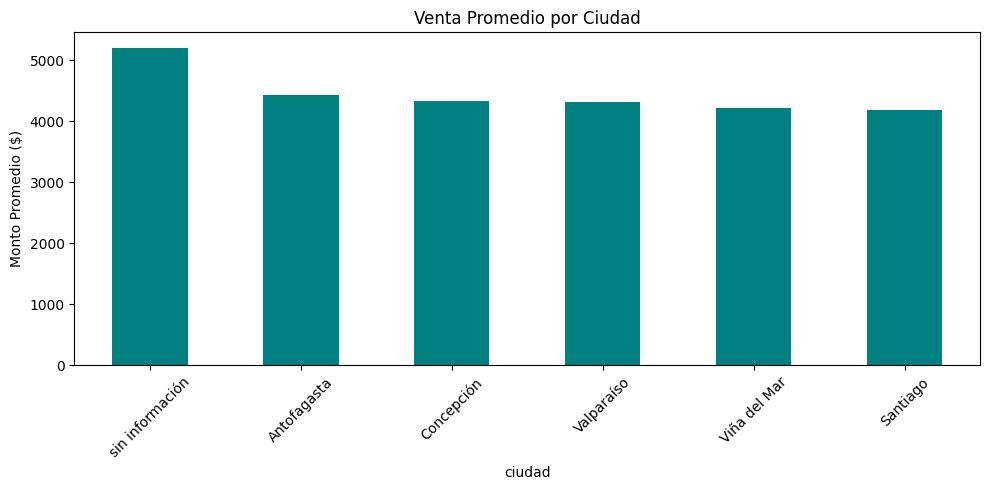

In [15]:
# 1. Generación de archivos de datos sintéticos
import pandas as pd
import numpy as np
from faker import Faker

# Inicialización de Faker
fake = Faker('es_ES')

# CLIENTES
n_clientes = 100
clientes = pd.DataFrame({
    'id_cliente': range(1, n_clientes + 1),
    'nombre': [fake.name() for _ in range(n_clientes)],
    'edad': np.random.choice(list(range(18, 70)) + [np.nan], n_clientes, p=[.01]*52 + [.48]),
    'ciudad': np.random.choice(['Santiago', 'Concepción', 'Valparaíso', 'Antofagasta', 'Sntiago', 'Vina del Mr', np.nan], n_clientes),
    'ingreso': np.round(np.random.normal(1800, 900, n_clientes), 0)
})
# Insertar outliers y nulos en ingreso
clientes.loc[np.random.choice(clientes.index, 4), 'ingreso'] = [10000, 0, 30000, np.nan]

clientes.to_csv('clientes.csv', index=False)

# VENTAS
n_ventas = 500
ventas = pd.DataFrame({
    'id_venta': range(1, n_ventas + 1),
    'id_cliente': np.random.choice(clientes['id_cliente'].tolist() + [np.nan], n_ventas),
    'fecha': pd.to_datetime(np.random.choice(
        pd.date_range('2023-01-01', '2024-12-31', freq='D'), n_ventas)),
    'producto': np.random.choice(['A', 'B', 'C', 'D', 'X'], n_ventas),
    'monto': np.round(np.random.uniform(500, 8000, n_ventas), 0)
})
# Errores en fecha
ventas.loc[np.random.choice(ventas.index, 7), 'fecha'] = [
    '2023/05/20', '31-12-2024', None, '2024-01-02', 'julio 2023', np.nan, '2024/03/15']
# Errores en monto
ventas.loc[np.random.choice(ventas.index, 5), 'monto'] = [np.nan, 50000, 0, None, -100]

ventas.to_excel('ventas.xlsx', index=False)

# --------------------------------------
# 2. Extracción y exploración de los datos

# Cargar los datos
clientes = pd.read_csv('clientes.csv')
ventas = pd.read_excel('ventas.xlsx')

# Explorar
print("\nClientes:")
print(clientes.head())
print("\nResumen de dataframe clientes:")
clientes.info()
print("\nvalores únicos\n",clientes.nunique())

print("\nVentas:")
print(ventas.head())
print("\nResumen de dataframe ventas:")
ventas.info()
print("\nvalores únicos\n",ventas.nunique())

# Duplicados
print("\nDuplicados en clientes:", clientes.duplicated().sum())
print("Duplicados en ventas:", ventas.duplicated().sum())

# --------------------------------------
# 3. Limpieza inicial y transformación de tipos

# Normalización de nombres de columnas
clientes.columns = clientes.columns.str.lower()
ventas.columns = ventas.columns.str.lower()

# Convertir fecha a formato datetime
ventas['fecha'] = pd.to_datetime(ventas['fecha'], errors='coerce')

# Arreglar errores de escritura en 'ciudad'
clientes['ciudad'] = clientes['ciudad'].replace({
    'Sntiago': 'Santiago',
    'Vina del Mr': 'Viña del Mar'
})

# Eliminar duplicados si hay
clientes = clientes.drop_duplicates()
ventas = ventas.drop_duplicates()

# --------------------------------------
# 4. Detección y tratamiento de valores perdidos

print("\nValores nulos en clientes:\n", clientes.isnull().sum())
print("\nValores nulos en ventas:\n", ventas.isnull().sum())

# edad: imputar con parte entera de la media
clientes['edad'] = clientes['edad'].fillna(int(clientes['edad'].mean()))

# ciudad: imputar con 'sin información'
clientes['ciudad'] = clientes['ciudad'].fillna('sin información')

# ingreso: imputar con la media
clientes['ingreso'] = clientes['ingreso'].fillna(clientes['ingreso'].mean())

# fecha: imputar con la moda (más frecuente)
moda_fecha = ventas['fecha'].mode()[0]
ventas['fecha'] = ventas['fecha'].fillna(moda_fecha)

# id_cliente: eliminar ventas sin cliente válido
ventas = ventas.dropna(subset=['id_cliente'])

# monto: imputar con mediana
ventas['monto'] = ventas['monto'].fillna(ventas['monto'].median())

# --------------------------------------
# 5. Detección y tratamiento de outliers

def detectar_outliers_iqr(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    inferior = Q1 - 1.5 * IQR
    superior = Q3 + 1.5 * IQR
    return col[(col < inferior) | (col > superior)]

# Edad
outliers_edad = detectar_outliers_iqr(clientes['edad'])
print(f"\nOutliers edad: {len(outliers_edad)}")

# Ingreso
outliers_ingreso = detectar_outliers_iqr(clientes['ingreso'])
print(f"Outliers ingreso: {len(outliers_ingreso)}")
clientes['ingreso'] = np.where(
    clientes['ingreso'] > outliers_ingreso.max(), outliers_ingreso.max(), clientes['ingreso'])

# Monto
outliers_monto = detectar_outliers_iqr(ventas['monto'])
print(f"Outliers monto: {len(outliers_monto)}")
ventas['monto'] = np.where(
    ventas['monto'] > outliers_monto.max(), outliers_monto.max(), ventas['monto'])

# Eliminar negativos o cero si no tienen sentido
ventas = ventas[ventas['monto'] > 0]

# --------------------------------------
# 6. Exportación y visualización

# Dataframe para análisis por ciudad
df_final = ventas.merge(clientes, on='id_cliente', how='left')

# Agrupar por ciudad
resumen_ciudad = df_final.groupby('ciudad')['monto'].mean().sort_values(ascending=False)
print("\nVentas promedio por ciudad:\n", resumen_ciudad)

# Guardar resumen y datos limpios
df_final.to_csv('ventas_limpias.csv', index=False)
resumen_ciudad.to_csv('resumen_ciudad.csv')

# Visualización
import matplotlib.pyplot as plt

resumen_ciudad.plot(kind='bar', title='Venta Promedio por Ciudad', figsize=(10, 5), color='teal')
plt.ylabel('Monto Promedio ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ventas_por_ciudad.png')
plt.show()


## Informe

**Transformaciones:** Se corrigieron errores en nombres y formatos, se convirtieron tipos y se limpiaron duplicados.  
**Nulos:** Los valores nulos fueron tratados según el tipo de dato y su impacto en el análisis. En edad se usó la parte entera de la media para mantener coherencia numérica. En ciudad se imputó con "sin información" para no introducir sesgo. Ingreso se completó con la media. Fecha se imputó con la moda para preservar la lógica temporal.
**Outliers:** Se detectaron con IQR y se aplicó winsorización. Montos negativos se eliminaron.  
**Limitaciones:** El pipeline es manual, se recomienda modularizar funciones, añadir validación y más visualizaciones para futuros análisis.
'''